### A weighted index of crypto tokens traded against ETH on Binance. Outputs a chart of the weighted index.

In [2]:
#requirements
import talib
import requests
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import time
from talib import abstract
from talib.abstract import *

In [3]:
# function to get the current price of a token 
def price(symbol, comparison_symbols=['EUR'], exchange=''):
    url = 'https://min-api.cryptocompare.com/data/price?fsym={}&tsyms={}'\
            .format(symbol.upper(), ','.join(comparison_symbols).upper())
    if exchange:
        url += '&e={}'.format(exchange)
    page = requests.get(url)
    data = page.json()
    return data

In [4]:
price('BTC', exchange='Coinbase')

{'EUR': 5619}

In [5]:
# gets the price of a token on a specific exchange for a time range
def daily_price_historical(symbol, comparison_symbol, all_data=True, limit=0, aggregate=1, exchange=''):
    url = 'https://min-api.cryptocompare.com/data/histoday?fsym={}&tsym={}&limit={}&aggregate={}'\
            .format(symbol.upper(), comparison_symbol.upper(), limit, aggregate)
    if exchange:
        url += '&e={}'.format(exchange)
    if all_data:
        url += '&allData=true'
    page = requests.get(url)
    data = page.json()['Data']
    df = pd.DataFrame(data)
    df['timestamp'] = [pd.datetime.fromtimestamp(d) for d in df.time]  
    df['timestamp'].format='%d%b%Y'
    df['timestamp'] = df['timestamp'].apply(lambda x: x.date())
    return df

In [6]:
df = daily_price_historical('ADA', 'ETH', exchange='Binance' )
df.head()

,close,high,low,open,time,volumefrom,volumeto,timestamp
0,0.000370,0.000438,0.000250,0.000281,1513209600,37272546,12298.35,2017-12-14
1,0.000317,0.000374,0.000268,0.000370,1513296000,41666676,13529.83,2017-12-15
2,0.000578,0.000698,0.000290,0.000317,1513382400,61897394,27835.76,2017-12-16
3,0.000679,0.000850,0.000528,0.000578,1513468800,62273414,41735.60,2017-12-17
4,0.000673,0.000715,0.000590,0.000679,1513555200,25395156,16666.05,2017-12-18


In [7]:
# gets all information available on the crypto info site 'cryptocompare.com' for a token
def coin_info(cid):
    url = 'https://www.cryptocompare.com/api/data/coinsnapshotfullbyid/?id='+ cid
    page = requests.get(url)
    data = page.json()['Data']
    return data

In [8]:
# gets the full list of tokens available at 'cryptocompare.com'
def coin_list():
    url = 'https://www.cryptocompare.com/api/data/coinlist/'
    page = requests.get(url)
    data = page.json()['Data']
    df = pd.DataFrame(data)
    return df

cl = coin_list()
cl

,NXT,BTCD,PPC,CRAIG,XBS,XPY,YBC,DANK,GIVE,KOBO,...,TRN,PLMT,DFXT,DOM*,BF,CMT,CMTC,NWP,MOV,BCDT
Algorithm,PoS,SHA256,N/A,X11,X11,SHA256,Multiple,X13,X11,X15,...,N/A,N/A,N/A,N/A,N/A,N/A,Scrypt,N/A,N/A,N/A
BuiltOn,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,...,7605,N/A,7605,30173,7605,7605,N/A,7605,7605,7605
CoinName,Nxt,BitcoinDark,PeerCoin,CraigsCoin,Bitstake,PayCoin,YbCoin,DarkKush,GiveCoin,KoboCoin,...,Ternion,Pallium,DigiFinexToken,Dominium,BitForex Token,CyberMiles,CometCoin,NWPSolution,MovieCoin,Blockchain Certified Data Token
FullName,Nxt (NXT),BitcoinDark (BTCD),PeerCoin (PPC),CraigsCoin (CRAIG),Bitstake (XBS),PayCoin (XPY),YbCoin (YBC),DarkKush (DANK),GiveCoin (GIVE),KoboCoin (KOBO),...,Ternion (TRN),Pallium (PLMT),DigiFinexToken (DFXT),Dominium (DOM),BitForex Token (BF),CyberMiles (CMT),CometCoin (CMTC),NWPSolution (NWP),MovieCoin (MOV),Blockchain Certified Data Token (BCDT)
FullyPremined,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Id,1183,4400,2349,4425,5023,5030,3639,3640,3641,3642,...,910733,847420,926176,925313,926179,439963,22354,926182,925615,926186
ImageUrl,/media/20627/nxt.png,/media/19630/btcd_1.png,/media/19864/peercoin-logo.png,/media/20022/craig.png,/media/351060/xbs_1.png,/media/20076/xpy_1.png,/media/19975/ybc.png,/media/20247/dank.png,/media/20297/give.png,/media/20329/kobo.png,...,/media/34155510/trn.png,/media/30002021/plmt.png,/media/34835898/digifinextoken.png,/media/34478238/dom.png,/media/34835899/bf.png,/media/30002257/cmt.png,/media/34835904/cmtc.png,/media/34835900/nwp.png,/media/34478422/mov.png,/media/34835902/bcdt.png
Name,NXT,BTCD,PPC,CRAIG,XBS,XPY,YBC,DANK,GIVE,KOBO,...,TRN,PLMT,DFXT,DOM,BF,CMT,CMTC,NWP,MOV,BCDT
PreMinedValue,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,...,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A
ProofType,PoS/LPoS,PoW/PoS,N/A,PoS,PoW/PoS,PoS,N/A,PoW/PoS,PoW,PoW/PoS,...,N/A,N/A,N/A,PoS,N/A,N/A,PoW,N/A,N/A,N/A


In [9]:
# gets the Ids of all tokens on 'cryptocompare.com'
def cc_ids_list(cl):
    ids = cl.loc['Id']
    ids = ids.tolist()
    return ids

ids = cc_ids_list(cl)

In [10]:
# filters tokens traded against ETH on the exchange 'Binance'
def coins_on_binance(ids):
    binance_coins = []
    for i in ids:
        try:
            g = coin_info(i)
            s = g['General']['Symbol']
            if '2~Binance~'+ s +'~ETH' in g['Subs']:
                binance_coins.append(s)
            time.sleep(1)    
        except Exception as e:
            print ('Could not load', i, e)
            pass
    return binance_coins     

In [ ]:
binance_coins = coins_on_binance(ids)

In [12]:
len(binance_coins)

143

In [18]:
# remove BCH from the list
binance_coins.remove('BCH')
print(binance_coins)

['LTC', 'DASH', 'XMR', 'ZEC', 'BTS', 'XRP', 'BTM', 'CLOAK', 'XVG', 'NAV', 'XLM', 'SYS', 'VIA', 'BCN', 'XEM', 'NXS', 'GRS', 'SC', 'REP', 'DGD', 'LSK', 'WAVES', 'STEEM', 'BNT', 'STRAT', 'SNGLS', 'ICN', 'WINGS', 'KMD', 'NEO', 'TRIG', 'XZC', 'ARDR', 'ARK', 'GNT', 'PIVX', 'RLC', 'LUN', 'BAT', 'QTUM', 'ZEN', 'IOT', 'SNM', 'SKY', 'SNT', 'CVC', 'DENT', 'NANO', 'CDT', 'DNT', 'FUN', 'MTL', 'PPT', 'OAX', 'ZRX', 'TNT', 'STORM', 'STORJ', 'OMG', 'POE', 'AE', 'VIB', 'MANA', 'BNB', 'MTH', 'DLT', 'SUB', 'NEBL', 'CTR', 'EVX', 'VET', 'AMB', 'WAN', 'ENJ', 'FUEL', 'WTC', 'RCN', 'LINK', 'EDO', 'KNC', 'TRX', 'SALT', 'LRC', 'HSR', 'ADA', 'YOYOW', 'ICX', 'REQ', 'ARN', 'VIBE', 'AST', 'CND', 'ENG', 'POWR', 'WABI', 'PHX', 'MDA', 'MOD', 'APPC', 'BTG', 'WPR', 'KEY', 'OST', 'DATA', 'INS', 'BCPT', 'NULS', 'GVT', 'QSP', 'BCD', 'LEND', 'AION', 'CMT*', 'GTO', 'TNB', 'BRD', 'ELF', 'NAS', 'QLC', 'GXS', 'AGI', 'THETA', 'IOST', 'ZIL', 'NPXS', 'BLZ', 'NCASH', 'POA', 'LOOM', 'TUSD', 'DOCK', 'HOT*', 'IOTX', 'QKC', 'MFT', 'ONT'

In [13]:
# gets the available supply of tokens traded against ETH on the exchange 'Binance'
def coin_info_cmc(binance_coins):
    url = 'https://api.coinmarketcap.com/v1/ticker/?limit=0'
    page = requests.get(url)  
    data = page.json()
    df = pd.DataFrame(data)
    df1 = df[['symbol','available_supply']]
    df1 = df1.set_index('symbol')
    binance_mc = df1.loc[df1.index.isin(binance_coins)]
    binance_mc = binance_mc.sort_index()
    return binance_mc

In [15]:
b_mcs = coin_info_cmc(binance_coins)
b_mcs.head()

,available_supply
symbol,
ADA,25927070538.0
ADX,73430701.0
AE,233020472.0
AGI,539673260.0
AION,242806287.0


In [16]:
# gets the current price of a token against ETH
def price(symbol, comparison_symbols=['ETH'], exchange=''):
    url = 'https://min-api.cryptocompare.com/data/price?fsym={}&tsyms={}'\
            .format(symbol.upper(), ','.join(comparison_symbols).upper())
    if exchange:
        url += '&e={}'.format(exchange)
    page = requests.get(url)
    data = page.json()
    f = {'SYM': symbol, 'Price': data['ETH']}   
    return f

In [17]:
# appends the price to the dataframe
def bc_prices_supply(binance_coins, available_supply):
    prices = []
    for c in binance_coins:
        p = price(c)
        prices.append(p)
    x = pd.DataFrame(prices)
    df = x.set_index('SYM')
    df1 = df.join(available_supply)
    return df1


In [18]:
rr = bc_prices_supply(binance_coins, b_mcs)
rr.head()

,Price,available_supply
ADA,0.000373,25927070538.0
ADX,0.001207,73430701.0
AE,0.006730,233020472.0
AGI,0.000259,539673260.0
AION,0.002108,242806287.0


In [19]:
# calculates the marketcap of the tokens
def calc_mc(coins_df):
    coins_df['market_cap'] = (coins_df['Price'] * coins_df['available_supply'].astype(float))
    return coins_df

In [20]:
bmc = calc_mc(rr)
bmc.head()

,Price,available_supply,market_cap
ADA,0.000373,25927070538.0,9.673390e+06
ADX,0.001207,73430701.0,8.863086e+04
AE,0.006730,233020472.0,1.568228e+06
AGI,0.000259,539673260.0,1.398293e+05
AION,0.002108,242806287.0,5.118357e+05


In [21]:
srt = bmc.sort_values('market_cap', ascending=False)

In [22]:
# selects the current top 100 tokens by marketcap
top100 = srt.iloc[:100]

In [24]:
top100.head()

,Price,available_supply,market_cap
XRP,0.002242,39997634397.0,8.967470e+07
EOS,0.026490,906245118.0,2.400643e+07
XLM,0.001195,18893406338.0,2.257762e+07
LTC,0.258500,58819677.0,1.520489e+07
ADA,0.000373,25927070538.0,9.673390e+06


In [25]:
lst100 = top100.index.tolist()

In [27]:
# calculates the total marketcap of the top 100 tokens
def total_mc(bmc):
    tmc = bmc['market_cap'].sum()
    return tmc

tmc = total_mc(top100)
tmc

259872324.16926026

In [54]:
# calculates the weight of a token
def load_coin_pi(coin, bmc, tmc):
    c = daily_price_historical(coin, 'ETH', exchange='Binance')
    c['part_index'] = ((bmc.at[coin, 'market_cap'] / tmc) * c['close'])
    c['Coin'] = (coin)
    df = c[['timestamp', 'part_index', 'Coin']]
    return df   

In [66]:
# appends the tokens to a dataframe
def join_coins(coin_dfs):
    df = pd.concat([d.set_index('timestamp') for d in coin_dfs], axis=1, sort=True) 
    return df

In [55]:
# calculates the weight for each token in the top 100 in a time range
def load_all_coins(binance_coins, bmc, tmc):
    coin_dfs = []
    for coin in binance_coins: 
        try:
            df = load_coin_pi(coin, bmc, tmc)
            coin_dfs.append(df)
            time.sleep(1)
        except Exception as e:  
            print ('Could not load', coin, e)
    return coin_dfs

s = load_all_coins(lst100, top100, tmc)
len(s)    

Could not load BLZ operands could not be broadcast together with shapes (2,) (257,) 
Could not load BLZ operands could not be broadcast together with shapes (2,) (257,) 


98

In [70]:
# the final dataframe
ll = join_coins(s)
ll.head()

,part_index,Coin,part_index,Coin,part_index,Coin,part_index,Coin,part_index,Coin,...,part_index,Coin,part_index,Coin,part_index,Coin,part_index,Coin,part_index,Coin
2017-07-27,NaN,NaN,0.000866,EOS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-07-28,NaN,NaN,0.000860,EOS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-07-29,NaN,NaN,0.000822,EOS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-07-30,NaN,NaN,0.000829,EOS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-07-31,NaN,NaN,0.000805,EOS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [71]:
del ll['Coin']

In [72]:
# calculate the final sum for the index in the time range
ll['Sum'] = ll['part_index'].sum(axis=1)
ll.head()

,part_index,part_index,part_index,part_index,part_index,part_index,part_index,part_index,part_index,part_index,...,part_index,part_index,part_index,part_index,part_index,part_index,part_index,part_index,part_index,Sum
2017-07-27,NaN,0.000866,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001080
2017-07-28,NaN,0.000860,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001068
2017-07-29,NaN,0.000822,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001024
2017-07-30,NaN,0.000829,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001031
2017-07-31,NaN,0.000805,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001021


In [73]:
%matplotlib inline

%pylab inline

pylab.rcParams['figure.figsize'] = (15, 9)  

Populating the interactive namespace from numpy and matplotlib


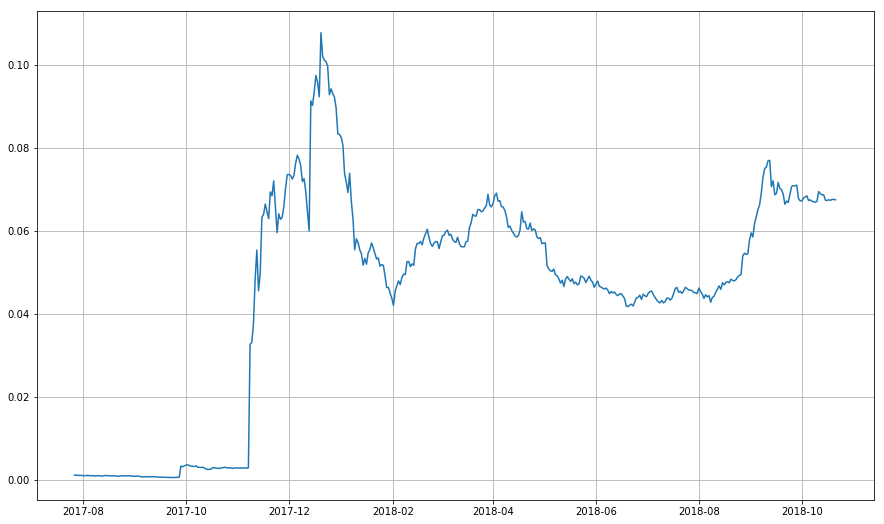

In [75]:
# plot the index
plt.grid(True)
plt.plot(ll['Sum'])